In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten

from sklearn.preprocessing import LabelEncoder, label_binarize
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

2025-06-07 20:20:14.176883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749327614.196026  239340 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749327614.201917  239340 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-07 20:20:14.223222: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train = pd.read_csv("train_QNN.csv")
val = pd.read_csv("val_QNN.csv")
test = pd.read_csv("test_QNN.csv")

In [3]:
def reducir_dataset(df, fraccion=0.05):
    df_reducido = []

    for proto_val in df['proto'].unique():
        df_proto = df[df['proto'] == proto_val]

        for clase in df_proto['category'].unique():
            df_clase = df_proto[df_proto['category'] == clase]

            # Si es ataque, mantener proporción por tipo de ataque
            if clase == 'Attack':
                # Agrupar por tipo de ataque y muestrear
                df_ataques = df_clase.groupby('ataque_original', group_keys=False).apply(
                    lambda x: x.sample(frac=fraccion, random_state=42)
                )
                df_reducido.append(df_ataques)
            else:
                # Benign no tiene subtipo, se muestrea directamente
                df_benign = df_clase.sample(frac=fraccion, random_state=42)
                df_reducido.append(df_benign)

    # Unir todo y mezclar
    df_final = pd.concat(df_reducido).sample(frac=1, random_state=42).reset_index(drop=True)
    return df_final


In [4]:
train = reducir_dataset(train, fraccion=0.05)
val = reducir_dataset(val, fraccion=0.05)
test = reducir_dataset(test, fraccion=0.05)

/tmp/ipykernel_239340/4273309696.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ataques = df_clase.groupby('ataque_original', group_keys=False).apply(
/tmp/ipykernel_239340/4273309696.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ataques = df_clase.groupby('ataque_original', group_keys=False).apply(
/tmp/ipykernel_239340/4273309696.py:13: DeprecationWarning: DataFrameGroupBy.apply operate

In [15]:
train.to_csv("train_VQC.csv", index=False)
val.to_csv("val_VQC.csv", index=False)
test.to_csv("test_VQC.csv", index=False)

In [5]:
X_train = train.drop(columns=['category', 'ataque_original'])
y_train = train['category']
label_train = train['ataque_original']

X_test = test.drop(columns=['category', 'ataque_original'])
y_test = test['category']
label_test = test['ataque_original']

X_val = val.drop(columns=['category', 'ataque_original'])
y_val = val['category']
label_val = val['ataque_original']

In [6]:
X_train.shape, X_test.shape, X_val.shape

((11179, 15), (3193, 15), (1596, 15))

In [7]:
# Normalización del conjunto de datos
norm = StandardScaler()

X_train = norm.fit_transform(X_train)
X_val = norm.transform(X_val)
X_test = norm.transform(X_test)

# Etiquetas codificadas
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

y_train = to_categorical(y_train_enc, num_classes=2)
y_val = to_categorical(y_val_enc, num_classes=2)
y_test = to_categorical(y_test_enc, num_classes=2)

In [8]:
model_filepath = 'Model15Feat/model-{epoch:02d}-{val_accuracy:.4f}.keras'
checkpoint = ModelCheckpoint(
    filepath = model_filepath,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    #verbose = 1
)

In [9]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Dense(16, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(8, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch = 200
steps_per_epoch = len(X_train) // batch
validation_steps = len(X_val) // batch

# Entrenar el modelo
history = model.fit(X_train,
                    y_train,
                    epochs=200, batch_size=batch,
                    validation_data=(X_val, y_val),
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps,
                    callbacks=[checkpoint])


/home/iraizozj/entorno/entorno/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749327640.389163  239340 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38484 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0
I0000 00:00:1749327640.390568  239340 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 35951 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
I0000 00:00:1749327640.392062  239340 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38484 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40G

Epoch 1/200


I0000 00:00:1749327642.301828  239698 service.cc:148] XLA service 0x7f6abc009710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749327642.301858  239698 service.cc:156]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1749327642.301861  239698 service.cc:156]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1749327642.301865  239698 service.cc:156]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1749327642.301868  239698 service.cc:156]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-06-07 20:20:42.334466: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749327642.429649  239698 cuda_dnn.cc:529] Loaded cuDNN version 90300


28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5019 - loss: 0.7393 

I0000 00:00:1749327644.070066  239698 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5280 - loss: 0.7239 - val_accuracy: 0.7307 - val_loss: 0.6356
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7654 - loss: 0.6656 - val_accuracy: 0.7393 - val_loss: 0.6345
Epoch 3/200
38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7488 - loss: 0.6251 

/home/iraizozj/entorno/entorno/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7548 - loss: 0.6246 - val_accuracy: 0.8014 - val_loss: 0.5900
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7933 - loss: 0.5919 - val_accuracy: 0.8014 - val_loss: 0.5894
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7978 - loss: 0.5893 - val_accuracy: 0.8021 - val_loss: 0.5589
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8659 - loss: 0.5494 - val_accuracy: 0.8021 - val_loss: 0.5584
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8030 - loss: 0.5596 - val_accuracy: 0.8021 - val_loss: 0.5287
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8045 - loss: 0.5135 - val_accuracy: 0.8014 - val_loss: 0.5283
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7977 - loss: 0.5379 - val_accuracy: 0.8029 - val_loss: 0.4951
Epoch 10/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8324 - loss: 0.4560 - val_accuracy: 0.8021 - val_loss: 0.

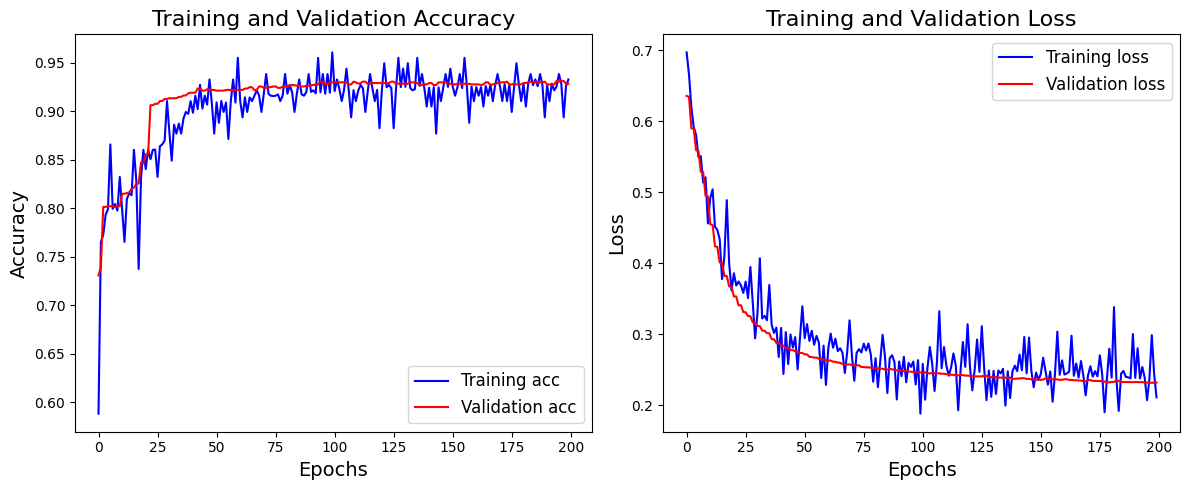

In [23]:
import matplotlib.pyplot as plt

# Datos
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Crear figura y subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax1.plot(epochs, acc, 'b', label='Training acc')
ax1.plot(epochs, val_acc, 'r', label='Validation acc')
ax1.set_title('Training and Validation Accuracy', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.legend(fontsize=12)

# Loss
ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and Validation Loss', fontsize=16)
ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_ylabel('Loss', fontsize=14)
ax2.legend(fontsize=12)

# Ajuste de espaciado y guardado
plt.tight_layout()
plt.savefig('NN2_train.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [11]:
#Importamos el modelo con mayor accuracy en validacion
MLP2 = load_model('Model15Feat/model-195-0.9314.keras')

In [12]:
y_pred_proba = MLP2.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [13]:
accuracy = accuracy_score(y_test_enc, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.9354838709677419


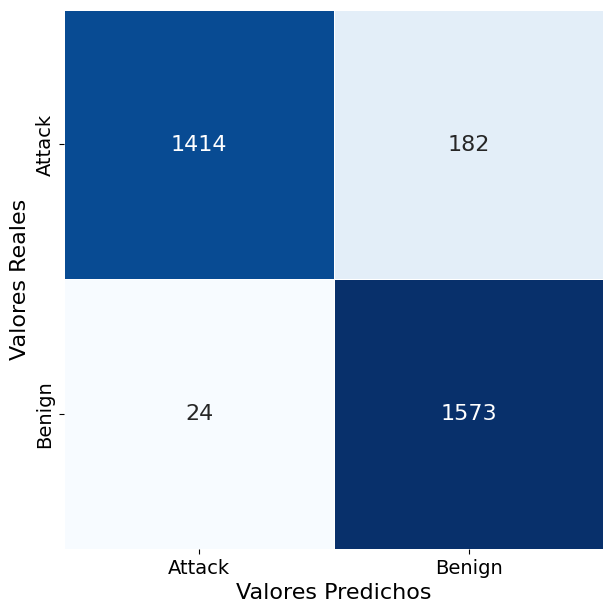

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Confusion matrix
cm = metrics.confusion_matrix(y_test_enc, y_pred)
normalized_matrix = cm  # O normaliza si quieres: cm / cm.sum(axis=1, keepdims=True)

class_names = ['Attack', 'Benign']

# Plot
sns.heatmap(
    normalized_matrix, 
    annot=True, 
    fmt='0.0f', 
    linewidth=0.5,
    annot_kws={"size": 16}, 
    xticklabels=class_names,
    yticklabels=class_names, 
    square=True, 
    cmap='Blues', 
    cbar=False
)

fig = plt.gcf()
fig.set_size_inches(7, 7)
plt.ylabel('Valores Reales', fontsize=16)
plt.xlabel('Valores Predichos', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Guardar como PDF (¡hazlo antes del plt.show!)
plt.savefig('CM_MLP2_15car_2ClassR.pdf', format='pdf', bbox_inches='tight')

plt.show()


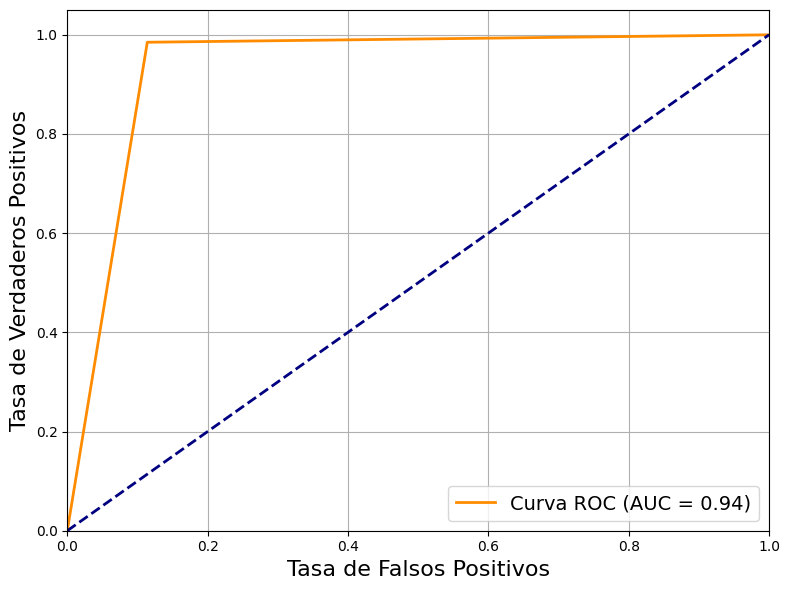

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular la curva ROC (usando las probabilidades de la clase positiva)
fpr, tpr, thresholds = roc_curve(y_test_enc, y_pred)  # ← y_pred_proba, no y_pred
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea aleatoria
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=16)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=16)
#plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('ROC_MLP2_15car_2ClassR.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
genuinos = []
impostores = []

for i in range(len(y_test_enc)):
    etiqueta_real = y_test_enc[i] 
    prob_predicha = y_pred_proba[i] 
    
    if etiqueta_real == 0:  # 0 = benigno
        score_genuino = prob_predicha[0]
        scores_impostores = prob_predicha[1:]  # ataque
        genuinos.append(score_genuino)
        impostores.extend(scores_impostores)


genuinos = np.array(genuinos)
impostores = np.array(impostores)

print("Genuinos:", genuinos.shape)
print("Impostores:", impostores.shape)


Genuinos: (3193,)
Impostores: (3193,)


In [34]:
thresholds = np.arange(0, 1.001, 0.001)
FAR = []
FRR = []
for threshold in thresholds:
    FAR.append(np.sum(impostores >= threshold) / len(impostores))
    FRR.append(np.sum(genuinos < threshold) / len(genuinos))

# Imprimir FAR, FRR y AUC
print("FAR:", FAR)
print("FRR:", FRR)

FAR: [np.float64(1.0), np.float64(0.9974945192608832), np.float64(0.8490447854682117), np.float64(0.7541497024741622), np.float64(0.7322267460068901), np.float64(0.7281553398058253), np.float64(0.7256498590667084), np.float64(0.7250234888819292), np.float64(0.7250234888819292), np.float64(0.7237707485123708), np.float64(0.6927654243658002), np.float64(0.6771061697463201), np.float64(0.6639523958659568), np.float64(0.6551832132790479), np.float64(0.6473535859693078), np.float64(0.6404635139367366), np.float64(0.6348261822737238), np.float64(0.6329470717193861), np.float64(0.6285624804259318), np.float64(0.6260569996868149), np.float64(0.6122768556216724), np.float64(0.6082054494206076), np.float64(0.6038208581271531), np.float64(0.6013153773880363), np.float64(0.6003758221108675), np.float64(0.5991230817413091), np.float64(0.59849671155653), np.float64(0.5972439711869715), np.float64(0.5966176010021923), np.float64(0.5950516755402443), np.float64(0.5944253053554651), np.float64(0.593172

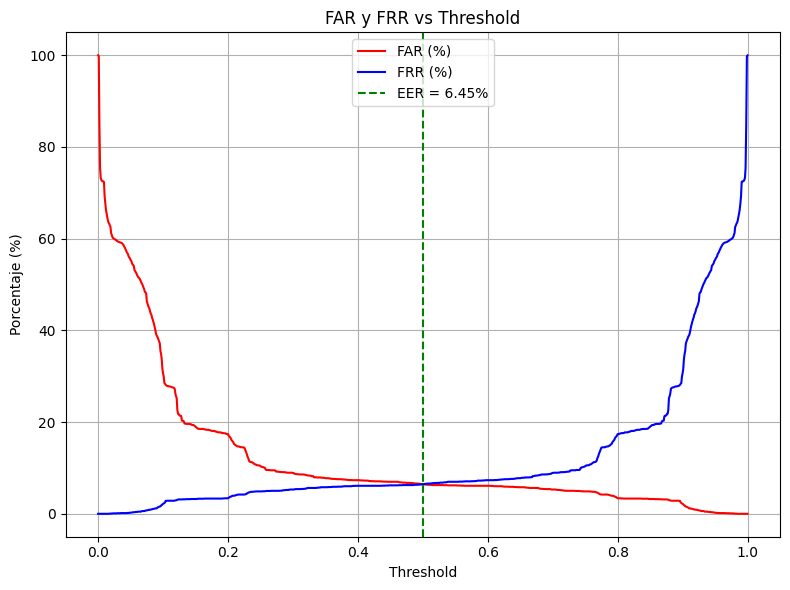

In [35]:
import matplotlib.pyplot as plt
import numpy as np

FAR_porcentaje = np.array(FAR) * 100
FRR_porcentaje = np.array(FRR) * 100

# Calcular EER
eer_threshold_index = np.nanargmin(np.abs(FAR_porcentaje - FRR_porcentaje))
eer_threshold = thresholds[eer_threshold_index]
eer = FAR_porcentaje[eer_threshold_index]

plt.figure(figsize=(8, 6))
plt.plot(thresholds, FAR_porcentaje, label='FAR (%)', color='red')
plt.plot(thresholds, FRR_porcentaje, label='FRR (%)', color='blue')
plt.axvline(eer_threshold, color='green', linestyle='--', label=f'EER = {eer:.2f}%')

plt.xlabel('Threshold')
plt.ylabel('Porcentaje (%)')
plt.title('FAR y FRR vs Threshold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('FAR_FRR_MLP2_15car_2ClassFull.pdf', format='pdf', bbox_inches='tight')
plt.show()
